#Clasificación de riesgo crediticio de los clientes para aplicaciones bancarias

Integrantes:
- Jonathan Gil (2166760)
- Jhos Hurtado (2170252)
- David Lucano (2170781)

##Instalación de dependencias

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report, precision_score, classification_report
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz

# from google.colab import drive
# drive.mount('/content/drive')

Se carga el dataset

In [ ]:
# df=pd.read_csv("/content/drive/MyDrive/Dataset_Aprendizaje/data.csv")
df = pd.read_csv("https://raw.githubusercontent.com/stevenLucano/datasets/main/dataset_riesgo_crediticio.csv")
df.head()

,checking_account,duration,credit_history,credit_purpose,amount,savings,current_employ,disposable_income,personal_status,guarantors,...,property,age,installment_plans,housing,existing_credits,job,people_liable,tel,foreign_worker,target
0,'<0',6,'critical/other existing credit',radio/tv,1169,'no known savings','>=7',4,'male single',none,...,'real estate',67,none,own,2,skilled,1,yes,yes,good
1,'0<=X<200',48,'existing paid',radio/tv,5951,'<100','1<=X<4',2,'female div/dep/mar',none,...,'real estate',22,none,own,1,skilled,1,none,yes,bad
2,'no checking',12,'critical/other existing credit',education,2096,'<100','4<=X<7',2,'male single',none,...,'real estate',49,none,own,1,'unskilled resident',2,none,yes,good
3,'<0',42,'existing paid',furniture/equipment,7882,'<100','4<=X<7',2,'male single',guarantor,...,'life insurance',45,none,'for free',1,skilled,2,none,yes,good
4,'<0',24,'delayed previously','new car',4870,'<100','1<=X<4',3,'male single',none,...,'no known property',53,none,'for free',2,skilled,2,none,yes,bad


##Preprocesamiento de datos

Primero se observa si tenemos datos nulos

In [ ]:
df.isnull().sum()

checking_account           0
duration                   0
credit_history             0
credit_purpose             0
amount                     0
savings                    0
current_employ             0
disposable_income          0
personal_status            0
guarantors                 0
current_residence_years    0
property                   0
age                        0
installment_plans          0
housing                    0
existing_credits           0
job                        0
people_liable              0
tel                        0
foreign_worker             0
target                     0
dtype: int64

Como no se tienen valores nulos dentro del dataset, se procede con la verificación de los tipos de valores dentro del mismo

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   checking_account         1000 non-null   object
 1   duration                 1000 non-null   int64 
 2   credit_history           1000 non-null   object
 3   credit_purpose           1000 non-null   object
 4   amount                   1000 non-null   int64 
 5   savings                  1000 non-null   object
 6   current_employ           1000 non-null   object
 7   disposable_income        1000 non-null   int64 
 8   personal_status          1000 non-null   object
 9   guarantors               1000 non-null   object
 10  current_residence_years  1000 non-null   int64 
 11  property                 1000 non-null   object
 12  age                      1000 non-null   int64 
 13  installment_plans        1000 non-null   object
 14  housing                  1000 non-null   

Los valores que aparecen tipo object son cadenas de texto que podemos clasificarla según el número de parametros únicos que tenga

In [ ]:
cat_cols = [col for col in df.columns if df[col].dtypes == "O"]
for col in cat_cols:
    print(df[col].value_counts(), "\n\n")

'no checking'    394
'<0'             274
'0<=X<200'       269
'>=200'           63
Name: checking_account, dtype: int64 


'existing paid'                     530
'critical/other existing credit'    293
'delayed previously'                 88
'all paid'                           49
'no credits/all paid'                40
Name: credit_history, dtype: int64 


radio/tv                280
'new car'               234
furniture/equipment     181
'used car'              103
business                 97
education                50
repairs                  22
'domestic appliance'     12
other                    12
retraining                9
Name: credit_purpose, dtype: int64 


'<100'                603
'no known savings'    183
'100<=X<500'          103
'500<=X<1000'          63
'>=1000'               48
Name: savings, dtype: int64 


'1<=X<4'      339
'>=7'         253
'4<=X<7'      174
'<1'          172
unemployed     62
Name: current_employ, dtype: int64 


'male single'           548
'fe

Se buscan y eliminan las filas duplicadas

In [ ]:
df.shape

(1000, 21)

In [ ]:
duplicate_rows_df = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows_df.shape)

number of duplicate rows:  (0, 21)


In [ ]:
df.count()

checking_account           1000
duration                   1000
credit_history             1000
credit_purpose             1000
amount                     1000
savings                    1000
current_employ             1000
disposable_income          1000
personal_status            1000
guarantors                 1000
current_residence_years    1000
property                   1000
age                        1000
installment_plans          1000
housing                    1000
existing_credits           1000
job                        1000
people_liable              1000
tel                        1000
foreign_worker             1000
target                     1000
dtype: int64

##Pruebas

Este apartado es solo demostrativo para eliminar los outliers, y observar los resultados que se obtiene, sin embargo, para las pruebas finales se debe saltar este paso.

In [ ]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

duration                     12.00
amount                     2606.75
disposable_income             2.00
current_residence_years       2.00
age                          15.00
existing_credits              1.00
people_liable                 0.00
dtype: float64


In [ ]:
df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
df.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  """Entry point for launching an IPython kernel.


(728, 21)

In [ ]:
print(df.isnull().sum())

checking_account           0
duration                   0
credit_history             0
credit_purpose             0
amount                     0
savings                    0
current_employ             0
disposable_income          0
personal_status            0
guarantors                 0
current_residence_years    0
property                   0
age                        0
installment_plans          0
housing                    0
existing_credits           0
job                        0
people_liable              0
tel                        0
foreign_worker             0
target                     0
dtype: int64


In [ ]:
df = df.dropna()
df.count()

checking_account           728
duration                   728
credit_history             728
credit_purpose             728
amount                     728
savings                    728
current_employ             728
disposable_income          728
personal_status            728
guarantors                 728
current_residence_years    728
property                   728
age                        728
installment_plans          728
housing                    728
existing_credits           728
job                        728
people_liable              728
tel                        728
foreign_worker             728
target                     728
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 728 entries, 6 to 997
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   checking_account         728 non-null    object
 1   duration                 728 non-null    int64 
 2   credit_history           728 non-null    object
 3   credit_purpose           728 non-null    object
 4   amount                   728 non-null    int64 
 5   savings                  728 non-null    object
 6   current_employ           728 non-null    object
 7   disposable_income        728 non-null    int64 
 8   personal_status          728 non-null    object
 9   guarantors               728 non-null    object
 10  current_residence_years  728 non-null    int64 
 11  property                 728 non-null    object
 12  age                      728 non-null    int64 
 13  installment_plans        728 non-null    object
 14  housing                  728 non-null    o

##Codificación con OneHot

In [ ]:
df[['checking_account', 'credit_history', 'credit_purpose', 'savings', 'current_employ', 'personal_status', 'guarantors', 'property', 'installment_plans', 'housing', 'job', 'tel', 'foreign_worker', 'target']]=df[['checking_account', 'credit_history', 'credit_purpose', 'savings', 'current_employ', 'personal_status', 'guarantors', 'property', 'installment_plans', 'housing', 'job', 'tel', 'foreign_worker', 'target']].astype("category")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   checking_account         1000 non-null   category
 1   duration                 1000 non-null   int64   
 2   credit_history           1000 non-null   category
 3   credit_purpose           1000 non-null   category
 4   amount                   1000 non-null   int64   
 5   savings                  1000 non-null   category
 6   current_employ           1000 non-null   category
 7   disposable_income        1000 non-null   int64   
 8   personal_status          1000 non-null   category
 9   guarantors               1000 non-null   category
 10  current_residence_years  1000 non-null   int64   
 11  property                 1000 non-null   category
 12  age                      1000 non-null   int64   
 13  installment_plans        1000 non-null   category
 14  housing  

In [ ]:
codificator = LabelBinarizer().fit(['good', 'bad'])
target_new = codificator.transform(df['target'].values)
#print(target_new)


In [ ]:
Codificador1 = OneHotEncoder()
Codificador2 = OneHotEncoder()
Codificador3 = OneHotEncoder()
Codificador4 = OneHotEncoder()
Codificador5 = OneHotEncoder()
Codificador6 = OneHotEncoder()
Codificador7 = OneHotEncoder()
Codificador8 = OneHotEncoder()
Codificador9 = OneHotEncoder()
Codificador10 = OneHotEncoder()
Codificador11 = OneHotEncoder()
Codificador12 = OneHotEncoder()
Codificador13 = OneHotEncoder()
Codificador14 = OneHotEncoder()


codificacion1 = Codificador1.fit_transform(df[["checking_account"]])
codificacion2 = Codificador2.fit_transform(df[["credit_history"]])
codificacion3 = Codificador3.fit_transform(df[["credit_purpose"]])
codificacion4 = Codificador4.fit_transform(df[["savings"]])
codificacion5 = Codificador5.fit_transform(df[["current_employ"]])
codificacion6 = Codificador6.fit_transform(df[["personal_status"]])
codificacion7 = Codificador7.fit_transform(df[["guarantors"]])
codificacion8 = Codificador8.fit_transform(df[["property"]])
codificacion9 = Codificador9.fit_transform(df[["installment_plans"]])
codificacion10 = Codificador10.fit_transform(df[["housing"]])
codificacion11 = Codificador11.fit_transform(df[["job"]])
codificacion12 = Codificador12.fit_transform(df[["tel"]])
codificacion13 = Codificador13.fit_transform(df[["foreign_worker"]])
codificacion14 = Codificador14.fit_transform(df[["target"]])



nuevas_cols1 =pd.DataFrame(codificacion1.toarray(), columns =Codificador1.categories_)
nuevas_cols2 =pd.DataFrame(codificacion2.toarray(), columns =Codificador2.categories_)
nuevas_cols3 =pd.DataFrame(codificacion3.toarray(), columns =Codificador3.categories_)
nuevas_cols4 =pd.DataFrame(codificacion4.toarray(), columns =Codificador4.categories_)
nuevas_cols5 =pd.DataFrame(codificacion5.toarray(), columns =Codificador5.categories_)
nuevas_cols6 =pd.DataFrame(codificacion6.toarray(), columns =Codificador6.categories_)
nuevas_cols7 =pd.DataFrame(codificacion7.toarray(), columns =Codificador7.categories_)
nuevas_cols8 =pd.DataFrame(codificacion8.toarray(), columns =Codificador8.categories_)
nuevas_cols9 =pd.DataFrame(codificacion9.toarray(), columns =Codificador9.categories_)
nuevas_cols10 =pd.DataFrame(codificacion10.toarray(), columns =Codificador10.categories_)
nuevas_cols11 =pd.DataFrame(codificacion11.toarray(), columns =Codificador11.categories_)
nuevas_cols12 =pd.DataFrame(codificacion12.toarray(), columns =Codificador12.categories_)
nuevas_cols13 =pd.DataFrame(codificacion13.toarray(), columns =Codificador13.categories_)


df = pd.concat([df, nuevas_cols1, nuevas_cols2, nuevas_cols3, nuevas_cols4, nuevas_cols5, nuevas_cols6, nuevas_cols7, nuevas_cols8, nuevas_cols9, nuevas_cols10, nuevas_cols11, nuevas_cols12, nuevas_cols13, nuevas_cols12, nuevas_cols13], axis="columns")
df.head(5)

,checking_account,duration,credit_history,credit_purpose,amount,savings,current_employ,disposable_income,personal_status,guarantors,...,"('unskilled resident',)","(skilled,)","(none,)","(yes,)","(no,)","(yes,)","(none,)","(yes,)","(no,)","(yes,)"
0,'<0',6,'critical/other existing credit',radio/tv,1169,'no known savings','>=7',4,'male single',none,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1,'0<=X<200',48,'existing paid',radio/tv,5951,'<100','1<=X<4',2,'female div/dep/mar',none,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,'no checking',12,'critical/other existing credit',education,2096,'<100','4<=X<7',2,'male single',none,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
3,'<0',42,'existing paid',furniture/equipment,7882,'<100','4<=X<7',2,'male single',guarantor,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,'<0',24,'delayed previously','new car',4870,'<100','1<=X<4',3,'male single',none,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


In [ ]:
df.drop(['checking_account', 'credit_history', 'credit_purpose', 'savings', 'current_employ', 'personal_status', 'guarantors', 'property', 'installment_plans', 'housing', 'job', 'tel', 'foreign_worker'], axis="columns", inplace=True)
df

,duration,amount,disposable_income,current_residence_years,age,existing_credits,people_liable,target,"('0<=X<200',)","('<0',)",...,"('unskilled resident',)","(skilled,)","(none,)","(yes,)","(no,)","(yes,)","(none,)","(yes,)","(no,)","(yes,)"
0,6,1169,4,4,67,2,1,good,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1,48,5951,2,2,22,1,1,bad,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,12,2096,2,3,49,1,2,good,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
3,42,7882,2,4,45,1,2,good,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,24,4870,3,4,53,2,2,bad,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12,1736,3,4,31,1,1,good,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
996,30,3857,4,4,40,1,1,good,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
997,12,804,4,4,38,1,1,good,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
998,45,1845,4,4,23,1,1,bad,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


In [ ]:
df.drop(['target'], axis="columns", inplace=True)

Posterior codificar las variables nominales en valores de prescencia con OneHot, se eleiminan las columnas categoricas y se agregan los nuevos valores al dataset. Y finalmente se busca de un parametro de análisis para los datos.

##Normalizar los datos para trabajar

Una vez realizado el análisis de los tipos de variables unicas corroborando que no hayan valores de filas duplicados, se procede a normalizar los elementos para seguir

In [ ]:
#Separamos y recopilamos los datos del dataset
x=df.iloc[:,:]
y=target_new
#Normalizamos los datos
scaler1 = MinMaxScaler(feature_range=(0, 1))
scaler1.fit(x)
xnorm=scaler1.transform(x)
xnorm = np.array(xnorm)

#Ajustamos los datos de entrenamiento y de testeo
xtrain, xtest, ytrain, ytest = train_test_split(xnorm, y, test_size=0.3, random_state=0)
print(x.shape,y.shape)
print(xnorm.shape,y.shape)


(1000, 65) (1000, 1)
(1000, 65) (1000, 1)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


##Tratamiento de datos

###Metodo 1

En este metodo se usará la implementación del modelo de regresión logistica para clasificación.

In [ ]:
classifier= LogisticRegression(random_state=0).fit(xtrain, ytrain)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
predict1 = classifier.predict(xtest)

print(predict1)
print(ytest.T)
print("El accuracy presente en el modelo es",accuracy_score(ytest,predict1))
print("El error presente en el modelo es",mean_squared_error(ytest,predict1))
print("La precisión presente en el modelo es",precision_score(ytest,predict1))

[0 1 1 1 0 1 1 1 1 0 0 0 1 1 0 1 1 1 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 0 1 1 1 0 1
 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1
 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 0 0 0 1 1 1 1 1 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 0 1 0 1 1 0 0 1 1 1 1 1 1 0 1
 0 1 0 1 1 1 0 1 1 1 1 0 1 0 1 0 0 0 0 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1
 0 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 0 1 1 1 0 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1
 0 1 0 0]
[[1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 0
  1 1 0 1 0 1 1 1 1 0 0 1 1 1 0 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1
  1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0
  0 1 1 0 0 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0
  0 0 1 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 1 0 0 0 0 1 0 1 1 1 1 0 1 0 0 0 1 1
  1 1 1 0 1 0 1 1 1 

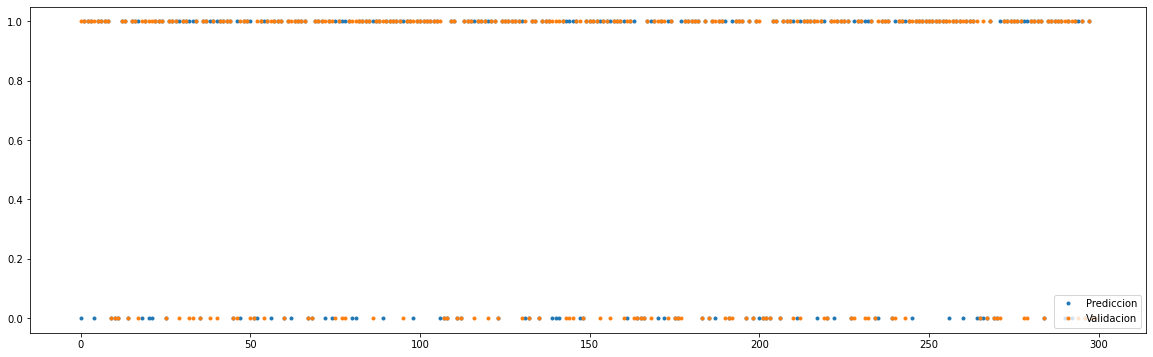

In [ ]:
fig, axs = plt.subplots(figsize=(20,6))

axs.plot(predict1,'.', label='Prediccion')
axs.plot(ytest,'.', label='Validacion')
axs.legend(loc='lower right')

####Matriz de confusión

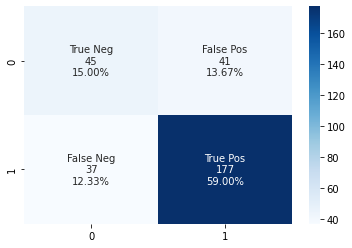

In [ ]:
a=confusion_matrix(ytest, predict1)
group_names = ['True Neg','False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                a.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     a.flatten()/np.sum(a)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(a, annot=labels, fmt='', cmap='Blues')

Entendiendose que esta matriz se puede leer de la siguiente manera

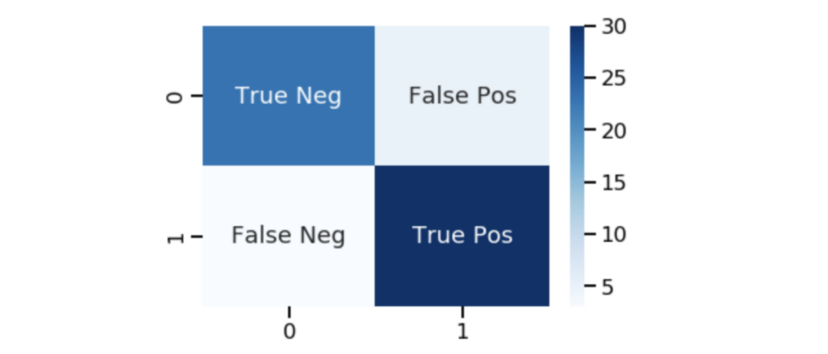

Finalizamos el modelo con un reporte de las metricas de la matriz de confusión

In [ ]:
print(classification_report(ytest, predict1))

              precision    recall  f1-score   support

           0       0.55      0.52      0.54        86
           1       0.81      0.83      0.82       214

    accuracy                           0.74       300
   macro avg       0.68      0.68      0.68       300
weighted avg       0.74      0.74      0.74       300



###Metodo 2

Estructura de clasificación por medio de arbol de decisión

In [ ]:
tree = DecisionTreeClassifier(random_state=0)
tree.fit(xtrain, ytrain)
print("Accuracy on training set: {:.3f}".format(tree.score(xtrain, ytrain)))
print("Accuracy on test set: {:.3f}".format(tree.score(xtest, ytest)))

Accuracy on training set: 1.000
Accuracy on test set: 0.713


In [ ]:
predict2 = tree.predict(xtest)
print(predict2)
print(ytest.T)
print("El accuracy presente en el modelo es",accuracy_score(ytest,predict2))
print("El error presente en el modelo es",mean_squared_error(ytest,predict2))
print("La precisión presente en el modelo es",precision_score(ytest,predict2))


[0 0 1 0 1 1 0 1 1 0 1 0 1 0 0 0 1 1 1 1 0 0 1 1 1 0 1 1 1 0 1 0 0 0 1 0 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0
 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 0 1 1 1 0 0 1 1 1
 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 1 0 1 1 1 1 1 0 1 0
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 0 1 1 0 1 1 0 0 1 0 0 0 0 1 1 1 0 0 1
 1 1 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 0 0
 1 1 1 1 1 0 0 1 1 1 0 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 0 1 0 1 1 1 0 0 1 1 0 1 1 0 1 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 0 1 0 0]
[[1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 0
  1 1 0 1 0 1 1 1 1 0 0 1 1 1 0 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1
  1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0
  0 1 1 0 0 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0
  0 0 1 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 1 0 0 0 0 1 0 1 1 1 1 0 1 0 0 0 1 1
  1 1 1 0 1 0 1 1 1 

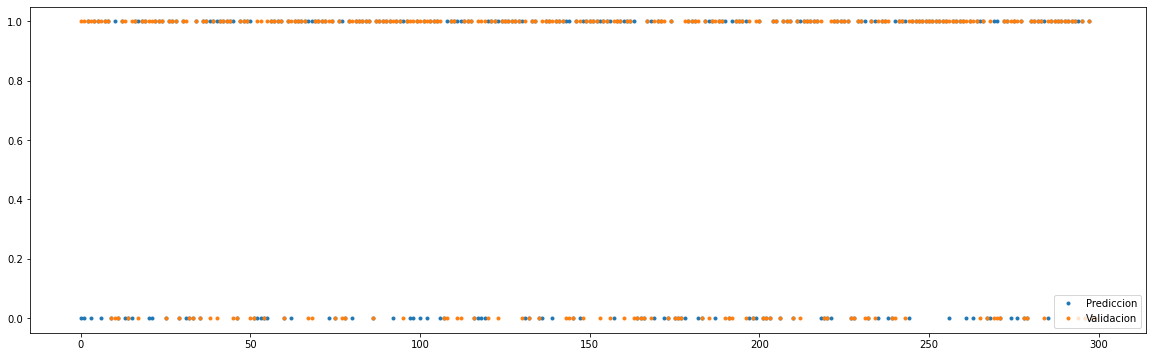

In [ ]:
fig, axs = plt.subplots(figsize=(20,6))

axs.plot(predict2,'.', label='Prediccion')
axs.plot(ytest,'.', label='Validacion')
axs.legend(loc='lower right')

####Matriz de confusión

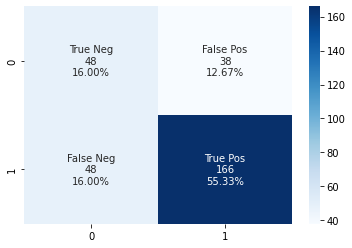

In [ ]:
b=confusion_matrix(ytest, predict2)
group_names = ['True Neg','False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                b.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     b.flatten()/np.sum(a)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(b, annot=labels, fmt='', cmap='Blues')

In [ ]:
print(classification_report(ytest, predict2))

              precision    recall  f1-score   support

           0       0.50      0.56      0.53        86
           1       0.81      0.78      0.79       214

    accuracy                           0.71       300
   macro avg       0.66      0.67      0.66       300
weighted avg       0.72      0.71      0.72       300



###Metodo 3

In [ ]:
random_forest_classifier = RandomForestClassifier(random_state=0, n_estimators=10, max_depth=15)
random_forest_classifier.fit(xtrain, ytrain)
random_forest_classifier.score(xtrain, ytrain)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.9814285714285714

In [ ]:
predict3 = random_forest_classifier.predict(xtest)
print(predict3)
print(ytest.reshape((1,-1)))
print("El accuracy presente en el modelo es",accuracy_score(ytest,predict3))
print("El error presente en el modelo es",mean_squared_error(ytest,predict3))
print("La precisión presente en el modelo es",precision_score(ytest,predict3))

[0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 0 1 0 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1
 1 0 1 1 0 1 1 1 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1
 0 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 0 1 1 0 1 1 0 0 0 0 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 0 1 1 0 0 0 1 1 1 1 1 0 0
 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 0 1 1 1 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1
 0 1 0 0]
[[1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 0
  1 1 0 1 0 1 1 1 1 0 0 1 1 1 0 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1
  1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0
  0 1 1 0 0 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0
  0 0 1 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 1 0 0 0 0 1 0 1 1 1 1 0 1 0 0 0 1 1
  1 1 1 0 1 0 1 1 1 

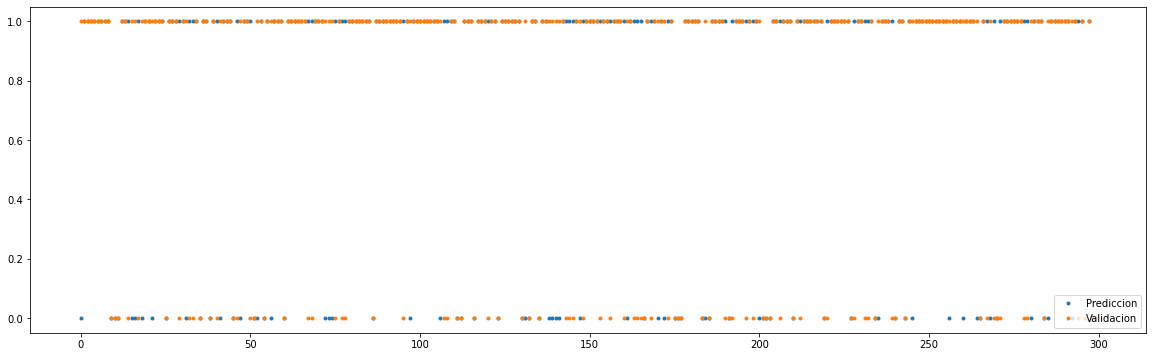

In [ ]:
fig, axs = plt.subplots(figsize=(20,6))

axs.plot(predict3,'.', label='Prediccion')
axs.plot(ytest,'.', label='Validacion')
axs.legend(loc='lower right')

####FEATURES IMPORTANCE PARA LOS PARAMETROS DEL DATASET

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
importance = random_forest_classifier.feature_importances_
print(importance)

[0.09505473 0.12123237 0.02762394 0.03116782 0.07170371 0.02117525
 0.01354157 0.0203164  0.03046555 0.00460853 0.06095055 0.019582
 0.02153708 0.00962074 0.01056261 0.01513031 0.00215966 0.02191163
 0.01447917 0.00840853 0.00570806 0.00943516 0.00187785 0.00739992
 0.00579974 0.001599   0.00452812 0.0065067  0.01249488 0.00450132
 0.01484287 0.01320205 0.00884004 0.01748956 0.01321877 0.00759589
 0.00943434 0.00602389 0.00371173 0.01118057 0.00530043 0.00497572
 0.00720398 0.01133249 0.00723446 0.01357473 0.00865749 0.00911112
 0.02023217 0.00467253 0.01580603 0.01472161 0.01167188 0.01475384
 0.00239901 0.01137456 0.01060811 0.0098143  0.00776809 0.00293228
 0.00179914 0.0085773  0.00723256 0.0010951  0.00052848]


In [ ]:
z=list(df.columns.values)
print(type(z))

#print(strings)
d=list(importance)
print(d)
feature_names = [f"{z[i]}" for i in range(x.shape[1])]
print(feature_names)

<class 'list'>
[0.09505473253923645, 0.12123236688931842, 0.02762394253967263, 0.031167824754927288, 0.07170371048264851, 0.02117525205201539, 0.013541567066733248, 0.020316403573838848, 0.03046555247467774, 0.004608531094620562, 0.060950552714841975, 0.01958199628746383, 0.02153707599061725, 0.009620740344791585, 0.010562613105479228, 0.015130314907349531, 0.0021596570743810306, 0.02191163432897621, 0.014479166811145005, 0.008408530649083396, 0.005708055582035997, 0.00943515805187938, 0.0018778465276393318, 0.007399919491026407, 0.0057997380456090465, 0.0015989982768591202, 0.0045281231430944644, 0.006506698754511575, 0.012494881094165185, 0.004501316773258589, 0.014842869865990399, 0.013202047681878984, 0.008840044269546307, 0.01748955846472143, 0.013218766799408432, 0.007595892606519404, 0.009434343185307344, 0.00602388522374863, 0.0037117308394400486, 0.01118056863191159, 0.0053004310222769194, 0.004975721493263642, 0.007203976466639559, 0.011332489738982652, 0.007234460954249065, 

<BarContainer object of 65 artists>

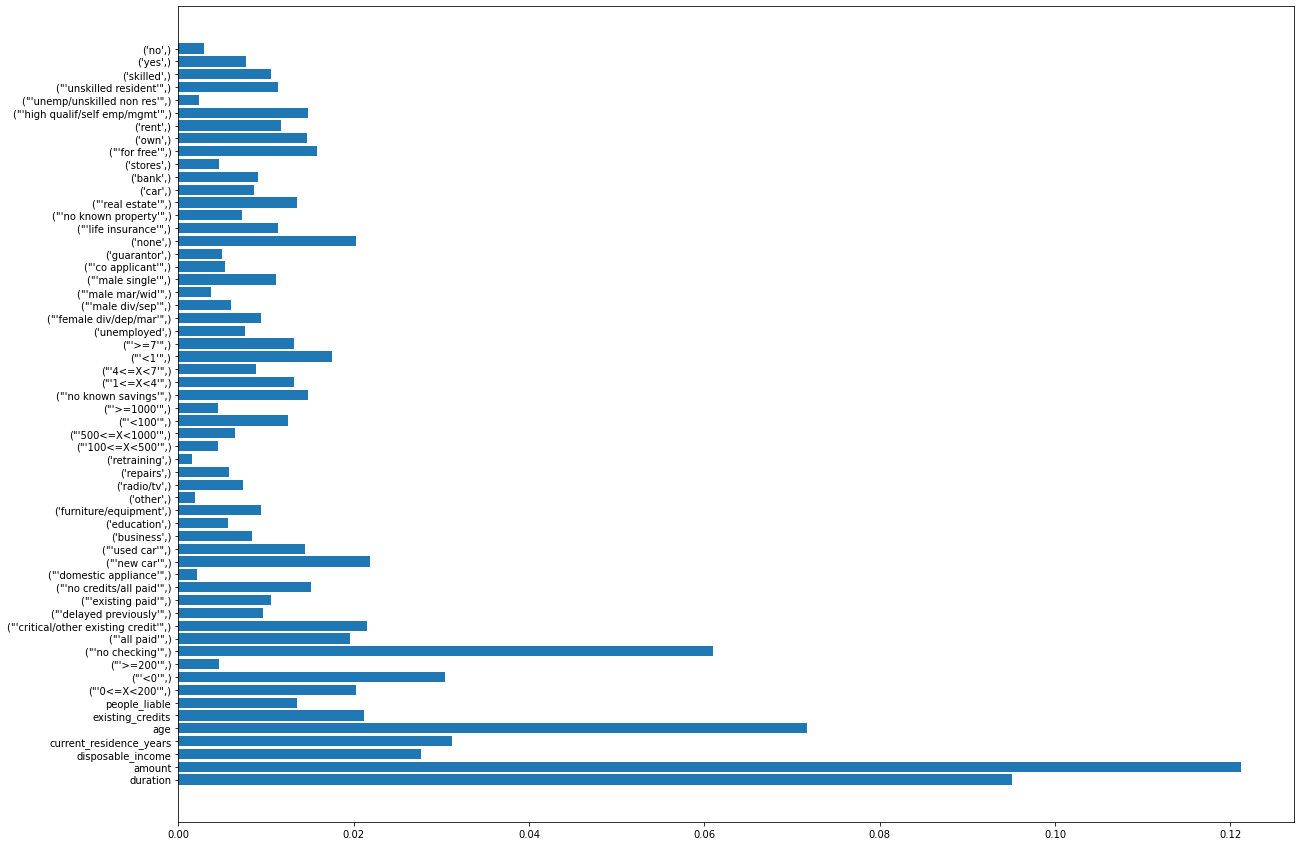

In [ ]:
fig, ax = plt.subplots(figsize =(20, 15))
ax.barh(feature_names, d)
#plt.show()

####Matriz de confusión

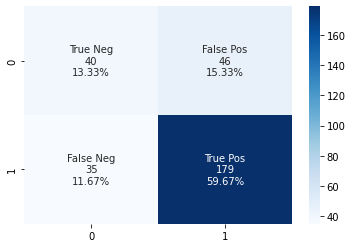

In [ ]:
c=confusion_matrix(ytest, predict3)
group_names = ['True Neg','False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                c.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     c.flatten()/np.sum(a)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(c, annot=labels, fmt='', cmap='Blues')

In [ ]:
print(classification_report(ytest, predict3))

              precision    recall  f1-score   support

           0       0.53      0.47      0.50        86
           1       0.80      0.84      0.82       214

    accuracy                           0.73       300
   macro avg       0.66      0.65      0.66       300
weighted avg       0.72      0.73      0.72       300



##Conclusiones

Usamos la curva de ROC para ilustrar las relaciones de los 3 metodos de entrenamiento, en conjunto con la tasa acierto de los modelos.

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

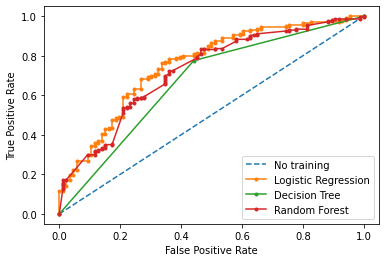


ROC AUC Logistic Regression: 0.754
ROC AUC Decision Tree: 0.667
ROC AUC Random Forest: 0.724


In [ ]:
ns_probs = [0 for _ in range(len(ytest))]
lr_probs1 = classifier.predict_proba(xtest)
lr_probs2 = tree.predict_proba(xtest)
lr_probs3 = random_forest_classifier.predict_proba(xtest)
#Nos quedamos con las probabilidades de la clase positiva (la probabilidad de 1)
lr_probs1 = lr_probs1[:, 1]
lr_probs2 = lr_probs2[:, 1]
lr_probs3 = lr_probs3[:, 1]
# Calculamos el AUC
ns_auc = roc_auc_score(ytest, ns_probs)
lr_auc = roc_auc_score(ytest, lr_probs1)
# Imprimimos en pantalla
#print('Sin entrenar: ROC AUC=%.3f' % (ns_auc))
#print('Regresión Logística: ROC AUC=%.3f' % (lr_auc))
# Calculamos las curvas ROC
ns_fpr1, ns_tpr1, _ = roc_curve(ytest, ns_probs)
lr_fpr1, lr_tpr1, _ = roc_curve(ytest, lr_probs1)
lr_fpr2, lr_tpr2, _ = roc_curve(ytest, lr_probs2)
lr_fpr3, lr_tpr3, _ = roc_curve(ytest, lr_probs3)

# Area bajo la curva ROC
lr_auc1 = roc_auc_score(ytest, lr_probs1)
lr_auc2 = roc_auc_score(ytest, lr_probs2)
lr_auc3 = roc_auc_score(ytest, lr_probs3)

# Pintamos las curvas ROC
pyplot.plot(ns_fpr1, ns_tpr1, linestyle='--', label='No training')

#'Regresión Logística: ROC AUC=%.3f' % (lr_auc)
pyplot.plot(lr_fpr1, lr_tpr1, marker='.', label="Logistic Regression")

pyplot.plot(lr_fpr2, lr_tpr2, marker='.', label="Decision Tree")

pyplot.plot(lr_fpr3, lr_tpr3, marker='.', label="Random Forest")
# Etiquetas de los ejes
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

print("\nROC AUC Logistic Regression: %.3f" % lr_auc1)
print("ROC AUC Decision Tree: %.3f" % lr_auc2)
print("ROC AUC Random Forest: %.3f" % lr_auc3)